<a href="https://colab.research.google.com/github/jacomof/MachineLearningClass/blob/main/APA_Practical_Work_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Joaquín Figueira Chacón  
Judith Vázquez Valero

# APA Practical Work

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import LinearSVR, SVR
from sklearn.neural_network import MLPRegressor
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/listings.csv')

## Preprocessing

In [ ]:
data.shape

(16206, 74)

In [ ]:
data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20210910193102,2021-09-10,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,Mireia And Maria,2010-01-19,"Barcelona, Catalonia, Spain","We are Mireia (43) & Maria (45), two multiling...",within an hour,100%,83%,f,https://a0.muscache.com/im/users/71615/profile...,https://a0.muscache.com/im/users/71615/profile...,la Sagrada Família,35.0,35.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.40556,2.17262,Entire rental unit,Entire home/apt,8,NaN,2 baths,3.0,6.0,"[""TV"", ""Wifi"", ""Hair dryer"", ""Washer"", ""Dedica...",$121.00,1,1125,1.0,3.0,1125.0,1125.0,1.6,1125.0,NaN,t,1,26,50,58,2021-09-10,21,0,0,2014-03-02,2019-10-11,4.40,4.55,4.75,4.80,4.90,4.75,4.30,HUTB-002062,t,19,19,0,0,0.23
1,23197,https://www.airbnb.com/rooms/23197,20210910193102,2021-09-11,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,90417,https://www.airbnb.com/users/show/90417,Etain (Marnie),2010-03-09,"Catalonia, Spain","Hi. I'm Etain, though everyone calls me by my...",within an hour,100%,70%,f,https://a0.muscache.com/im/users/90417/profile...,https://a0.muscache.com/im/users/90417/profile...,El Besòs i el Maresme,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.41291,2.22063,Entire rental unit,Entire home/apt,6,NaN,2 baths,3.0,5.0,"[""TV"", ""Washer"", ""Bed linens"", ""Hangers"", ""Pai...",$229.00,4,300,4.0,7.0,1125.0,1125.0,4.1,1125.0,NaN,t,22,52,82,128,2021-09-11,52,0,0,2016-01-05,2019-12-15,4.74,4.92,4.92,4.94,4.98,4.67,4.69,HUTB-005057,f,2,2,0,0,0.75
2,32711,https://www.airbnb.com/rooms/32711,20210910193102,2021-09-10,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,https://www.airbnb.com/users/show/135703,Nick,2010-05-31,"Barcelona, Catalonia, Spain",I'm Nick your English host in Barcelona.\r\n\r...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/135703/profil...,https://a0.muscache.com/im/users/135703/profil...,Camp d'en Grassot i Gràcia Nova,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41

**Variables numéricas**

In [ ]:
data.select_dtypes(exclude=['object']).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_pe

In [ ]:
len(list(data.select_dtypes(exclude=['object']).columns))

39

Eliminaremos las variables que representan identificadores. Cada una de las observaciones representa una oferta de alojamiento diferente, así que esta variable no nos aporta información que pueda resultar útil a alguno de los modelos a la hora de predecir el precio del alojamiento.

In [ ]:
data = data.drop(columns=['id', 'scrape_id', 'host_id'])

Vemos que las variables _host_listings_count_ y _host_total_listings_count_ son iguales, así que eliminamos una de ellas.

In [ ]:
pd.DataFrame(data['host_total_listings_count'] - data['host_listings_count']).value_counts()

0.0    16166
dtype: int64

In [ ]:
data = data.drop(columns=['host_total_listings_count'])

Tenemos unas cuantas variables relacionadas con el número mínimo y máximo de noches que se puede reservar en cada alojamiento.

In [ ]:
nights = ['minimum_nights', 'maximum_nights',
          'minimum_minimum_nights', 'maximum_minimum_nights',
          'minimum_maximum_nights', 'maximum_maximum_nights',
          'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

In [ ]:
data[nights]

,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
0,1,1125,1.0,3.0,1125.0,1125.0,1.6,1125.0
1,4,300,4.0,7.0,1125.0,1125.0,4.1,1125.0
2,2,31,2.0,2.0,31.0,31.0,2.0,31.0
3,4,365,3.0,4.0,365.0,365.0,4.0,365.0
4,2,60,2.0,2.0,1125.0,1125.0,2.0,1125.0
...,...,...,...,...,...,...,...,...
16201,32,1125,32.0,32.0,1125.0,1125.0,32.0,1125.0
16202,32,200,32.0,32.0,200.0,200.0,32.0,200.0
16203,32,150,32.0,32.0,150.0,150.0,32.0,150.0
16204,4,1125,1.0,4.0,1125.0,1125.0,3.8,1125.0


En el diccionario de datos de Airbnb se indica que _minimum_nights_ y _maximum_nights_ son el número mínimo y máximo de noches que se pueden pasar en el alojamiento según la oferta, es decir, según lo que el anfitrión indique. Según entendemos, el resto de variables las incluye Airbnb para corregir contradicciones o ambigüedades que el anfitrión pueda haber cometido al introducir los números. Por ejemplo, si el anfitrión exige un mínimo de una noche para todas las reservas, pero un mínimo de tres noches para los fines de semana, y un huésped solicita reservar un viernes, se le exigirá que reserve tres noches, no solo una. En ese caso habría una variable mínimo de 3 noches y una variable mínimo mínimo de 1 noche.

Pensamos que es buena idea quedarnos solo con _minimum_nights_ y _maximum_nights_.

In [ ]:
data = data.drop(columns=['minimum_minimum_nights', 'maximum_minimum_nights',
          'minimum_maximum_nights', 'maximum_maximum_nights',
          'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'])

La variable _calendar_updated_ tiene NaNs en todas las observaciones y no hay información al respecto en el diccionario de datos, así que la eliminaremos.

In [ ]:
data['calendar_updated'].isna().all()

True

In [ ]:
data = data.drop(columns=['calendar_updated'])

**Variables categóricas**

In [ ]:
data.select_dtypes(include=['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'price', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'instant_bookable'],
      dtype='object')

In [ ]:
len(list(data.select_dtypes(include=['object']).columns))

35

Eliminaremos las variables que hagan referencia a URLs.

In [ ]:
data = data.drop(columns=['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'])

En cuanto a fechas...

In [ ]:
fechas = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

In [ ]:
data[fechas]

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
0,2021-09-10,2010-01-19,2021-09-10,2014-03-02,2019-10-11
1,2021-09-11,2010-03-09,2021-09-11,2016-01-05,2019-12-15
2,2021-09-10,2010-05-31,2021-09-10,2013-02-28,2019-09-06
3,2021-09-11,2010-01-24,2021-09-11,2013-07-01,2020-03-11
4,2021-09-11,2010-06-25,2021-09-11,2014-06-15,2021-07-21
...,...,...,...,...,...
16201,2021-09-11,2017-05-14,2021-09-11,NaN,NaN
16202,2021-09-11,2009-03-19,2021-09-11,NaN,NaN
16203,2021-09-11,2011-12-14,2021-09-11,NaN,NaN
16204,2021-09-11,2018-08-29,2021-09-11,NaN,NaN


Las variables _last_scraped_ y _calendar_last_scraped_ las podemos eliminar porque indican cuándo se recopiló toda la información de la plataforma Airbnb para ponerla en el dataset (días 10 y 11 de septiembre del 2021).

In [ ]:
data['last_scraped'].value_counts()

2021-09-11    11764
2021-09-10     4442
Name: last_scraped, dtype: int64

In [ ]:
data['calendar_last_scraped'].value_counts()

2021-09-11    11757
2021-09-10     4449
Name: calendar_last_scraped, dtype: int64

In [ ]:
data = data.drop(columns=['last_scraped', 'calendar_last_scraped'])

De las fechas en las que se publicó la primera y la última valoración del alojamiento también prescindiremos. De la fecha en la que el anfitrión se registró en la plataforma extraeremos los años de antigüedad.

In [ ]:
years = []
for x in data['host_since']:
  if type(x) != str:  # nan
    years.append(-1)
  else:
    years.append(2022 - int(x.split('-')[0]))

data['host_years'] = years

In [ ]:
data['host_years'].value_counts()

 3     2190
 9     1833
 7     1822
 4     1720
 10    1575
 5     1540
 6     1504
 8     1369
 2     1028
 11     956
 1      389
 12     217
-1       40
 13      22
 14       1
Name: host_years, dtype: int64

In [ ]:
data = data.drop(columns=['host_since', 'first_review', 'last_review'])

Tampoco usaremos la licencia/permiso para registrar el alojamiento.

In [ ]:
data = data.drop(columns=['license'])

En cuanto a las variables relacionadas con la localización del alojamiento...

In [ ]:
data[['neighborhood_overview', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']]

,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,Apartment in Barcelona located in the heart of...,"Barcelona, CT, Spain",la Sagrada Família,Eixample
1,Strategically located in the Parc del Fòrum ar...,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí
2,What's nearby <br />This apartment is located...,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia
3,"Located in Ciutat Vella in the Gothic Quarter,...","Barcelona, Catalonia, Spain",el Barri Gòtic,Ciutat Vella
4,"Though located centrally, we're on a residenti...","Barcelona, Catalunya, Spain",l'Antiga Esquerra de l'Eixample,Eixample
...,...,...,...,...
16201,NaN,NaN,el Poble Sec,Sants-Montjuïc
16202,Typical barcelonian neighbourhood full of serv...,"Barcelona, Catalunya, Spain",la Nova Esquerra de l'Eixample,Eixample
16203,NaN,NaN,Sant Gervasi - Galvany,Sarrià-Sant Gervasi
16204,NaN,NaN,l'Antiga Esquerra de l'Eixample,Eixample


Prescindiremos de _neighbourhood_ (que es en realidad la ciudad), porque sabemos que todos los alojamientos se encuentran en Barcelona. Además lo comprobamos viendo que todos los distritos (_neighbourhood_group_cleansed_) se corresponden con los distritos de esta ciudad. 

In [ ]:
data = data.drop(columns=['neighbourhood', 'neighbourhood_cleansed'])

In [ ]:
data['neighbourhood_group_cleansed'].value_counts()

Eixample               5776
Ciutat Vella           3701
Sants-Montjuïc         1826
Sant Martí             1525
Gràcia                 1444
Sarrià-Sant Gervasi     611
Horta-Guinardó          512
Les Corts               357
Sant Andreu             231
Nou Barris              223
Name: neighbourhood_group_cleansed, dtype: int64

Prescindiremos de _neighbourhood_cleansed_, el barrio. Creemos que el distrito ya proporciona bastante información con respecto a la localización, y transformar la variable del barrio a numérica haciendo *one-hot encoding* resultaría en un dataset demasiado complejo por la cantidad de barrios diferentes que hay. Entonces, podría ser más fácil que el modelo hiciera overfitting.

De los anfitriones eliminaremos los nombres, los barrios y ciudades y las descripciones.

In [ ]:
data[['host_name', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified']]

,host_name,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified
0,Mireia And Maria,"Barcelona, Catalonia, Spain","We are Mireia (43) & Maria (45), two multiling...",within an hour,100%,83%,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t
1,Etain (Marnie),"Catalonia, Spain","Hi. I'm Etain, though everyone calls me by my...",within an hour,100%,70%,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
2,Nick,"Barcelona, Catalonia, Spain",I'm Nick your English host in Barcelona.\r\n\r...,within an hour,100%,100%,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t
3,Andres,"Barcelona, Catalonia, Spain","Hello I am a Professional designer, a traveler...",within an hour,100%,83%,t,"['email', 'phone', 'reviews', 'manual_offline'...",t,t
4,Pablo,"Barcelona, Cataluña, Spain",I was born and raised in Argentina and I moved...,within an hour,90%,100%,t,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
...,...,...,...,...,...,...,...,...,...,...
16201,Daiga,ES,NaN,within a day,88%,63%,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
16202,Weflating,"Barcelona, Catalonia, Spain",Hola! Somos Weflating Apartments un equipo de ...,within an hour,94%,85%,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
16203,Laia,"Barcelona, Cataluña, Spain",Hola a todos! Os mando un saludo muy fuerte y ...,a few days or more,0%,NaN,f,"['email', 'phone', 'facebook', 'reviews']",t,t
16204,Quim,CA,"Hi, I'm Quim. I love welcoming guests from all...",within an hour,94%,50%,f,"['email', 'phone', 'google', 'offline_governme...",t,t


In [ ]:
data = data.drop(columns=['host_name', 'host_location', 'host_neighbourhood'])

**Variable _price_**

La variable _price_ figura como categórica porque está en un string con el símbolo $. En realidad tiene que ser numérica, por lo que representa. Además, aunque aparezca con el \$, el diccionario de Airbnb indica que el valor es en la moneda local.

In [ ]:
data['price'] = data['price'].str[1:]
data['price'] = [x.replace(',', '') for x in data['price']]
data['price'] = pd.to_numeric(data['price'])

In [ ]:
data['price'].describe()

count    16206.000000
mean       109.258299
std        294.915363
min          0.000000
25%         40.000000
50%         70.000000
75%        122.000000
max       9999.000000
Name: price, dtype: float64

En esta descripción vemos valores bastante dispares. Sobretodo llama la atención que el 75% de alojamientos tienen un precio inferior a 122€ pero el valor máximo casi alcanza los 10000€. La desviación es muy alta.

Si miramos la descripción para el 25% de alojamientos más caros, encontramos algo similar. El 75% de alojamientos tienen un precio inferior a 240€ pero la media supera ese valor.

In [ ]:
caros = data[data['price'] > 122]
caros['price'].describe()

count    4032.000000
mean      262.377728
std       561.845273
min       123.000000
25%       143.000000
50%       170.000000
75%       240.000000
max      9999.000000
Name: price, dtype: float64

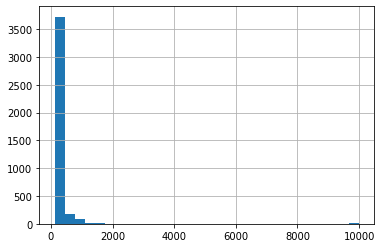

In [ ]:
caros['price'].hist(bins=30)
plt.show()

In [ ]:
len(caros[caros['price'] > 1000])

48

In [ ]:
len(data)

16206

### Detección y tratamiento de missing values

In [ ]:
def missing_table(df):
  missing_data = pd.DataFrame({'total_missing': df.isna().sum(),
                             'percent_missing': df.isna().sum() * 100 / df.shape[0]})
  missing_data = missing_data[missing_data['total_missing'] > 0]
  missing_data = missing_data.sort_values(by='percent_missing', ascending=False)
  return missing_data

Antes de empezar con esto, miraremos qué variables categóricas sin missing values tenemos que pasar a numéricas. Este paso es necesario para su procesamiento por algunos modelos y para algunos métodos de imputación.

#### One-hot encoding

In [ ]:
data.select_dtypes(include='object').columns

Index(['name', 'description', 'neighborhood_overview', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'bathrooms_text', 'amenities',
       'has_availability', 'instant_bookable'],
      dtype='object')

In [ ]:
missing_table(data.select_dtypes(include='object')).index

Index(['neighborhood_overview', 'host_about', 'host_acceptance_rate',
       'host_response_time', 'host_response_rate', 'description',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'bathrooms_text', 'name'],
      dtype='object')

A la variable _host_verifications_ no le vamos a dar demasiada importancia y la eliminaremos. En el diccionario no se indica su significado, pero entendemos que representa las maneras en las que el anfitrión ha verificado su identidad. Además, hacer one-hot encoding de esta variable haría aparecer muchísimas variables nuevas que podrían entorpecer el funcionamiento de los modelos.

In [ ]:
data['host_verifications'].value_counts()

['email', 'phone']                                                                                                                  2304
['email', 'phone', 'reviews', 'jumio', 'government_id']                                                                             1498
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']                       1147
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']                                  1082
['email', 'phone', 'reviews']                                                                                                        966
                                                                                                                                    ... 
['email', 'phone', 'manual_online', 'google', 'reviews', 'manual_offline']                                                             1
['email', 'phone', 'facebook', 'reviews',

In [ ]:
data = data.drop(columns=['host_verifications'])

Por el mismo motivo, hacer one-hot encoding de la variable _amenities_ tampoco parece buena idea. Sin embargo, esta puede proporcionarnos una información de interés que es si se permiten estancias largas en el alojamiento: 'Long term stays allowed'. De _amenities_ extraeremos esta nueva variable booleana, y luego haremos one-hot encoding de esta. También extraeremos una variable numérica que representará cuántas comodidades tiene el alojamiento.

In [ ]:
data['amenities'].value_counts()

["Wifi", "Microwave", "Kitchen", "Heating", "Hot water", "Long term stays allowed"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                              72
["Wifi", "Kitchen", "Heating", "Hot water", "Long term stays allowed"]                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
long_term = []
for am in data['amenities']:
  if "Long term stays allowed" in am:
    long_term.append(True)
  else:
    long_term.append(False)
data['long_term_stays'] = long_term

In [ ]:
data['num_amenities'] = [len(am) for am in data['amenities']]
data = data.drop(columns=['amenities'])

In [ ]:
data['long_term_stays'].value_counts()

True     14490
False     1716
Name: long_term_stays, dtype: int64

In [ ]:
dummies = pd.get_dummies(data['long_term_stays'], prefix='long_term_stays')
data = data.drop(columns=['long_term_stays'])
data = data.join(dummies)

De las variables _room_type_ y _property_type_ haremos one-hot encoding solo de _room_type_ y eliminaremos la otra, por el mismo motivo: muchos valores posibles que aumentarían el número de variables en el dataset y que podrían producir overfitting en el modelo.

In [ ]:
data['room_type'].value_counts()

Entire home/apt    8678
Private room       7104
Hotel room          241
Shared room         183
Name: room_type, dtype: int64

In [ ]:
data['property_type'].value_counts()

Entire rental unit                     7519
Private room in rental unit            5768
Entire serviced apartment               411
Entire loft                             279
Room in boutique hotel                  262
Entire condominium (condo)              260
Private room in condominium (condo)     242
Private room in residential home        222
Private room in hostel                  137
Room in hotel                           134
Private room in serviced apartment      129
Shared room in hostel                    90
Private room in bed and breakfast        83
Private room in guest suite              78
Entire residential home                  65
Room in hostel                           59
Private room in loft                     58
Shared room in rental unit               57
Entire guest suite                       40
Room in serviced apartment               32
Boat                                     28
Private room in casa particular          28
Private room                    

In [ ]:
dummies = pd.get_dummies(data['room_type'], prefix='room_type')
data = data.drop(columns=['room_type'])
data = data.join(dummies)

In [ ]:
data = data.drop(columns=['property_type'])

Ya solo nos quedan _neighbourhood_group_cleansed, _has_availability_ y _instant_bookable_, para las que haremos one-hot encoding.

In [ ]:
dummies = pd.get_dummies(data['neighbourhood_group_cleansed'], prefix='district')
data = data.drop(columns=['neighbourhood_group_cleansed'])
data = data.join(dummies)

In [ ]:
dummies = pd.get_dummies(data['has_availability'], prefix='has_availability')
data = data.drop(columns=['has_availability'])
data = data.join(dummies)

In [ ]:
dummies = pd.get_dummies(data['instant_bookable'], prefix='instant_bookable')
data = data.drop(columns=['instant_bookable'])
data = data.join(dummies)

#### Variables numéricas

In [ ]:
num = data.select_dtypes(exclude='object')
missing_table(num)

,total_missing,percent_missing
bathrooms,16206,100.000000
review_scores_value,4587,28.304332
review_scores_location,4586,28.298161
review_scores_checkin,4585,28.291991
review_scores_accuracy,4582,28.273479
review_scores_communication,4580,28.261138
review_scores_cleanliness,4579,28.254967
review_scores_rating,4417,27.255338
reviews_per_month,4417,27.255338
bedrooms,558,3.443169


La variable _bathrooms_ tiene missing values en todas las filas. En la versión de los datos que tenemos, esta variable ha quedado inutilizada: hay una nueva (_bathrooms_text_) que nos indica cuántos baños tiene el alojamiento. Como ya tenemos la información que necesitamos en esa variable, vamos a eliminar _bathrooms_.

In [ ]:
data = data.drop(columns=['bathrooms'])

Vemos un número similar de missing values en las variables relacionadas con las valoraciones y puntuaciones, lo que nos hace pensar que es posible que los missing values en estas variables pertenezcan a las mismas filas/observaciones.

In [ ]:
missing_reviews = data[data['review_scores_value'].isna()
                        & data['review_scores_location'].isna()
                        & data['review_scores_checkin'].isna()
                        & data['review_scores_accuracy'].isna()
                        & data['review_scores_communication'].isna()
                        & data['review_scores_cleanliness'].isna()
                        & data['review_scores_rating'].isna()
                        & data['reviews_per_month'].isna()]

In [ ]:
len(missing_reviews)

4417

In [ ]:
100*len(missing_reviews)/len(data)

27.255337529310133

4417 filas tienen missing values en las variables relacionadas con las valoraciones. Tenemos varias opciones:
- Imputar de alguna manera estos valores
- Eliminar las filas afectadas

Eliminar estas filas supondría eliminar casi el 30% de las observaciones del dataset, que es una pérdida de información importante. Por otro lado, si pensamos en por qué motivo estas filas tienen missing values en estas variables, es posible que imputar no tenga mucho sentido. Es posible que el motivo sea que el alojamiento/oferta no tiene valoraciones o que se ha dado de baja de la plataforma.


In [ ]:
data = data.drop(index=missing_reviews.index)

Para las variables _beds_, _bedrooms_ y _host_listings_count_, al tener pocos missing values, hemos usado la media para imputar.

In [ ]:
data['bedrooms'][data['bedrooms'].isna()] = data['bedrooms'].mean()
data['beds'][data['beds'].isna()] = data['beds'].mean()
data['host_listings_count'][data['host_listings_count'].isna()] = data['host_listings_count'].mean()

In [ ]:
num = data.select_dtypes(exclude='object')
missing_table(num)

,total_missing,percent_missing
review_scores_value,170,1.442022
review_scores_location,169,1.433540
review_scores_checkin,168,1.425057
review_scores_accuracy,165,1.399610
review_scores_communication,163,1.382645
review_scores_cleanliness,162,1.374162


En este punto, siguen quedando algunas observaciones con missing values en las valoraciones. Como no se han eliminado antes, significa que sí que tienen algún valor en las variables _review_scores_rating_ o _reviews_per_month_.

In [ ]:
missing_reviews = data[data['review_scores_value'].isna()
                        & data['review_scores_location'].isna()
                        & data['review_scores_checkin'].isna()
                        & data['review_scores_accuracy'].isna()
                        & data['review_scores_communication'].isna()
                        & data['review_scores_cleanliness'].isna()]

In [ ]:
len(missing_reviews)

161

In [ ]:
missing_reviews['review_scores_rating'].value_counts()

0.0    158
5.0      3
Name: review_scores_rating, dtype: int64

In [ ]:
missing_table(missing_reviews)

,total_missing,percent_missing
review_scores_accuracy,161,100.000000
review_scores_cleanliness,161,100.000000
review_scores_checkin,161,100.000000
review_scores_communication,161,100.000000
review_scores_location,161,100.000000
review_scores_value,161,100.000000
host_acceptance_rate,113,70.186335
host_response_time,104,64.596273
host_response_rate,104,64.596273
host_about,103,63.975155


La gran mayoría de estas tienen un rating de 0 y tienden a tener missing values también en las variables que representan las respuestas del anfitrión a las reservas. Por esto, parece lo correcto hacer la misma interpretación que hemos hecho anteriormente y eliminar estas filas.

In [ ]:
data = data.drop(index=missing_reviews.index)

Para las que queden (que pueden tener missing value en alguna de estas variables, pero no en todas), imputaremos con la media.

In [ ]:
missing_reviews.columns

Index(['name', 'description', 'neighborhood_overview', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_year

In [ ]:
l = ['review_scores_value', 'review_scores_location', 'review_scores_checkin',
     'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness']
for var in l:
  data[var][data[var].isna()] = data[var].mean()

#### Variables categóricas

In [ ]:
cat = data.select_dtypes(include='object')
missing_table(cat)

,total_missing,percent_missing
neighborhood_overview,3991,34.322325
host_about,3911,33.634331
host_response_time,2802,24.097007
host_response_rate,2802,24.097007
host_acceptance_rate,2799,24.071207
description,29,0.249398
host_is_superhost,28,0.240798
host_has_profile_pic,28,0.240798
host_identity_verified,28,0.240798
bathrooms_text,5,0.043000


La variable _neighborhood_overview_ es una descripción del barrio en el que se encuentra un alojamiento (que ha sido escrita por el anfitrión) y presenta un 34% de missing values. Como desconocemos métodos para imputar valores de este tipo (textos, descripciones) y la cantidad de missing values es bastante alta, eliminamos esta variable.

In [ ]:
data['neighborhood_overview']

0        Apartment in Barcelona located in the heart of...
1        Strategically located in the Parc del Fòrum ar...
2        What's nearby  <br />This apartment is located...
3        Located in Ciutat Vella in the Gothic Quarter,...
4        Though located centrally, we're on a residenti...
                               ...                        
16090    Sants is a quiet and safe neighbourhood in Bar...
16091    Sants is a quiet and safe neighbourhood in Bar...
16092                                                  NaN
16097    Located in the Gothic neighborhood, you will b...
16119                                                  NaN
Name: neighborhood_overview, Length: 11628, dtype: object

In [ ]:
data = data.drop(columns=['neighborhood_overview'])

Por los mismos motivos por los que hemos decidido eliminar la variable _neighborhood_overview_, también decidimos prescindir de _host_about_.

In [ ]:
data['host_about']

0        We are Mireia (43) & Maria (45), two multiling...
1        Hi.  I'm Etain, though everyone calls me by my...
2        I'm Nick your English host in Barcelona.\r\n\r...
3        Hello I am a Professional designer, a traveler...
4        I was born and raised in Argentina and I moved...
                               ...                        
16090    SmartRoom Barcelona ofrece la calidad que quie...
16091    SmartRoom Barcelona ofrece la calidad que quie...
16092                                                  NaN
16097                                                  NaN
16119    Hi I'm a friendly and easy going Australian. I...
Name: host_about, Length: 11628, dtype: object

In [ ]:
data = data.drop(columns=['host_about'])

De nuevo vemos un número similar de missing values en las variables que representan las respuestas del anfitrión a las reservas de sus alojamientos. Abajo también comprobamos que los missing values están en las mismas observaciones.

In [ ]:
missing_host = data[data['host_response_time'].isna()
                  & data['host_response_rate'].isna()
                  & data['host_acceptance_rate'].isna()]

In [ ]:
missing_table(missing_host)

,total_missing,percent_missing
host_response_time,2527,100.000000
host_response_rate,2527,100.000000
host_acceptance_rate,2527,100.000000
host_is_superhost,28,1.108033
host_has_profile_pic,28,1.108033
host_identity_verified,28,1.108033
description,5,0.197863
name,4,0.158290


Para la variable _host_acceptance_rate_, que indica la tasa de aceptación del anfitrión, usaremos la media para imputar los missing values. En un principio habíamos considerado imputar estos valores usando 1NN, teniendo en cuenta otras variables como _host_response_rate_ pero viendo que la tasa de aceptación suele ser bastante alta y la desviación estándar es baja pensamos que la media puede ser una buena forma de imputar.

In [ ]:
data['host_acceptance_rate']

0         83%
1         70%
2        100%
3         83%
4        100%
         ... 
16090     98%
16091     98%
16092    100%
16097    100%
16119    100%
Name: host_acceptance_rate, Length: 11628, dtype: object

Primero, la convertimos a variable numérica.

In [ ]:
data['host_acceptance_rate'] = data['host_acceptance_rate'].str[:-1]
data['host_acceptance_rate'] = pd.to_numeric(data['host_acceptance_rate'])/100.0
data['host_acceptance_rate']

0        0.83
1        0.70
2        1.00
3        0.83
4        1.00
         ... 
16090    0.98
16091    0.98
16092    1.00
16097    1.00
16119    1.00
Name: host_acceptance_rate, Length: 11628, dtype: float64

In [ ]:
data['host_acceptance_rate'].describe()

count    8829.000000
mean        0.853166
std         0.253044
min         0.000000
25%         0.830000
50%         0.970000
75%         1.000000
max         1.000000
Name: host_acceptance_rate, dtype: float64

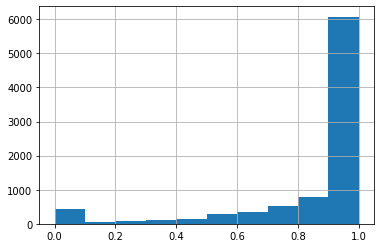

In [ ]:
data['host_acceptance_rate'].hist()
plt.show()

In [ ]:
data['host_acceptance_rate'][data['host_acceptance_rate'].isna()] = data['host_acceptance_rate'].mean()

Para _host_response_rate_ y _host_response_time_ intentaremos imputar los missing values usando 1NN con las variables numéricas, ya sin missing values, que tenemos.

Primero hace falta pasar _host_response_rate_ a numérica y hacer one-hot encoding de _host_response_time_.

In [ ]:
data['host_response_rate'] = pd.to_numeric(data['host_response_rate'].str[:-1])

In [ ]:
data['host_response_time'].value_counts()

within an hour        5696
within a few hours    1665
within a day          1053
a few days or more     412
Name: host_response_time, dtype: int64

In [ ]:
dummies = pd.get_dummies(data['host_response_time'], prefix='host_response_time')
data = data.drop(columns=['host_response_time'])
data = data.join(dummies)

In [ ]:
inds = data.host_response_rate[data.host_response_rate.isna()].index
knn = KNeighborsClassifier(n_neighbors=1)
numeric_vars = data.select_dtypes(include=['float64', 'uint8', 'int64'])
subset_numvars = numeric_vars.drop(columns=['host_response_rate', 'host_response_time_a few days or more', 'host_response_time_within a day',
                  'host_response_time_within a few hours', 'host_response_time_within an hour'])
numeric_vars_without_missings = subset_numvars[numeric_vars['host_response_rate'].notna() &
                                           (
                                           (numeric_vars['host_response_time_a few days or more'] == 1) |
                                           (numeric_vars['host_response_time_within a day'] == 1) |
                                           (numeric_vars['host_response_time_within a few hours'] == 1) |
                                           (numeric_vars['host_response_time_within an hour'] == 1)) ]
train_y = numeric_vars['host_response_rate'][numeric_vars['host_response_rate'].notna() &
                                           (
                                           (numeric_vars['host_response_time_a few days or more'] == 1) |
                                           (numeric_vars['host_response_time_within a day'] == 1) |
                                           (numeric_vars['host_response_time_within a few hours'] == 1) |
                                           (numeric_vars['host_response_time_within an hour'] == 1)) ]

numeric_vars_with_missing = subset_numvars[numeric_vars.host_response_rate.isna()]
knn.fit(numeric_vars_without_missings, train_y)
knn_rate = knn.predict(numeric_vars_with_missing);
data.host_response_rate[data.host_response_rate.isna()] = knn_rate
data.host_response_rate[inds]

41       100.0
51       100.0
52       100.0
54       100.0
61       100.0
         ...  
15593     98.0
15609    100.0
15665    100.0
15953    100.0
16065     94.0
Name: host_response_rate, Length: 2802, dtype: float64

In [ ]:
cat = data.select_dtypes(include='object')
missing_table(cat)

,total_missing,percent_missing
description,29,0.249398
host_is_superhost,28,0.240798
host_has_profile_pic,28,0.240798
host_identity_verified,28,0.240798
bathrooms_text,5,0.043000
name,4,0.034400


Para las variables _name_ y _description_, de las que luego queremos extraer algo de información, sustituiremos los missing values con strings vacíos. Esta es la opción más sencilla, y teniendo en cuenta que estas variables tienen pocos missing values, no afectará gravemente al rendimiento de los modelos.

In [ ]:
data['name'][data['name'].isna()] = ''
data['description'][data['description'].isna()] = ''

La variable _bathrooms_text_ contiene información sobre el número de baños del alojamiento que en realidad debería ser numérica, pero que está codificada como string. Por ello aquí la transformamos a numérica.

In [ ]:
data['bathrooms_text'].value_counts()

1 bath               4618
1 shared bath        2332
2 baths              1961
1 private bath        769
1.5 shared baths      554
1.5 baths             528
2 shared baths        349
3 baths               163
2.5 baths              80
4 baths                59
2.5 shared baths       45
3 shared baths         27
3.5 baths              25
0 shared baths         22
5 baths                19
Shared half-bath       16
0 baths                12
6 baths                 9
Half-bath               8
5.5 baths               6
4 shared baths          4
7.5 baths               4
4.5 baths               3
Private half-bath       2
8 shared baths          2
11 shared baths         1
3.5 shared baths        1
8 baths                 1
4.5 shared baths        1
5 shared baths          1
6.5 baths               1
Name: bathrooms_text, dtype: int64

Primero nos quedamos con la palabra que hay antes del primer espacio, que suele ser el número de baños (exceptuando tres casos en los que indica si el baño es privado o compartido). Además hay algunos missing values, que rellenamos con un '0'.

In [ ]:
numeric_bathrooms = []
for value in data['bathrooms_text']:
  if type(value) == float:
    numeric_bathrooms.append('0')
  else:
    numeric_bathrooms.append(value.split(' ')[0])
data['bathrooms_text'] = numeric_bathrooms

A continuación pasamos los valores a numéricos. Entendemos que si la descripción dice que el baño es compartido o privado, se trata de un (1) baño. Si la descripción dice que es un 'medio baño', le damos valor 0.5.

In [ ]:
for value in ['Shared', 'Private']:
  data['bathrooms_text'][data['bathrooms_text'] == value] = '1'
  data['bathrooms_text'][data['bathrooms_text'] == 'Half-bath'] = '0.5'
data['bathrooms_text'] = pd.to_numeric(data['bathrooms_text'])

In [ ]:
data['bathrooms'] = data['bathrooms_text']
data = data.drop(columns=['bathrooms_text'])
data['bathrooms'].value_counts()

1.0     7737
2.0     2310
1.5     1082
3.0      190
2.5      125
4.0       63
0.0       39
3.5       26
5.0       20
6.0        9
0.5        8
5.5        6
7.5        4
4.5        4
8.0        3
11.0       1
6.5        1
Name: bathrooms, dtype: int64

Por último, hay tres variables booleanas, _host_is_superhost_, _host_has_profile_pic_ y _host_identity_verified_, que tienen 28 missing values. Esto representa un porcentaje muy pequeño de las observaciones así que decidimos simplemente imputar con el valor más frecuente de la variable.

In [ ]:
data['host_is_superhost'].value_counts()

f    9233
t    2367
Name: host_is_superhost, dtype: int64

In [ ]:
data['host_is_superhost'][data['host_is_superhost'].isna()] = 'f'

In [ ]:
data['host_has_profile_pic'].value_counts()

t    11569
f       31
Name: host_has_profile_pic, dtype: int64

In [ ]:
data['host_has_profile_pic'][data['host_has_profile_pic'].isna()] = 't'

In [ ]:
data['host_identity_verified'].value_counts()

t    9574
f    2026
Name: host_identity_verified, dtype: int64

In [ ]:
data['host_identity_verified'][data['host_identity_verified'].isna()] = 't'

A continuación hacemos one-hot encoding a estas variables.

In [ ]:
for var in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']:
  dummies = pd.get_dummies(data[var], prefix=var)
  data = data.drop(columns=[var])
  data = data.join(dummies)

### Preprocesado de los nombres y las descripciones de las ofertas

Nuestro objetivo es extraer algunas variables nuevas que nos permitan mantener la información que los nombres y descripciones proporcionan, pero en un formato que pueda ser útil para los modelos que vamos a usar. En concreto, para cada oferta, queremos extraer:
- La longitud del nombre y de la descripción
- La proporción de "palabras más frecuentes" que aparecen en estos campos

Con "palabras más frecuentes" nos referimos a las palabras que aparecen más frecuentemente en todos los nombres/descripciones (exceptuando artículos, preposiciones y _stop words_ en general). 

**Nota:** consideramos utilizar el _TfidfVectorizer_ que proporciona _scikit-learn_ para obtener un vector TF-IDF para cada nombre y descripción y después poder almacenarlo de alguna forma en variables, pero nos pareció que esto complicaría luego la interpretación.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Dos nuevas variables que representan la longitud de estos campos
data['name_length'] = [len(name) for name in data['name']]
data['description_length'] = [len(description) for description in data['description']]

In [ ]:
data['name_length'].describe()

count    11628.000000
mean        37.692810
std         11.461989
min          0.000000
25%         31.000000
50%         38.000000
75%         47.000000
max        241.000000
Name: name_length, dtype: float64

Para la variable _name_, trabajaremos con las 30 palabras más frecuentes. 

In [ ]:
data['description_length'].describe()

count    11628.000000
mean       781.120743
std        296.938162
min          0.000000
25%        543.000000
50%       1000.000000
75%       1000.000000
max       1000.000000
Name: description_length, dtype: float64

In [ ]:
data['description']

0        110m2 apartment to rent in Barcelona. Located ...
1        Beautiful spacious apartment, large terrace, 5...
2        A lovely two bedroom apartment only 250 m from...
3        Spacious apartment for large families or group...
4        Room at a my apartment. Kitchen and 2 bathroom...
                               ...                        
16090    <b>The space</b><br />Breakfast buffet not inc...
16091    <b>The space</b><br />Breakfast buffet not inc...
16092    nice triple room in raval<br /><br /><b>Licens...
16097    Newly renovated cozy bedroom with private bath...
16119    Kick back and relax in this calm, clean and st...
Name: description, Length: 11628, dtype: object

Para la variable _description_, trabajaremos con las 100 palabras más frecuentes.

In [ ]:
import re
data['description'] = [re.sub(r'<.*>', '', d) for d in data['description']]

In [ ]:
llt = [nltk.word_tokenize(sentence) for sentence in data['name']]
list_tokens_name = [token for lt in llt for token in lt]  # flatten de la lista de listas de tokens

In [ ]:
llt = [nltk.word_tokenize(sentence) for sentence in data['description']]
list_tokens_desc = [token for lt in llt for token in lt]  # flatten de la lista de listas de tokens

In [ ]:
# Nos quedamos solo con las palabras (y las pasamos todas a minuscula)
words_name = [word.lower() for word in list_tokens_name if word.isalpha()]
words_desc = [word.lower() for word in list_tokens_desc if word.isalpha()]

In [ ]:
stop_words_en = stopwords.words('english')
stop_words_es = stopwords.words('spanish')
print(stop_words_es)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [ ]:
# Nos deshacemos de las stop words
words_name = [w for w in words_name if not w in stop_words_en and not w in stop_words_es]
words_desc = [w for w in words_desc if not w in stop_words_en and not w in stop_words_es]

In [ ]:
most_frequent_name = pd.Series(words_name).value_counts()
most_frequent_name[:30]

apartment      2533
room           2505
barcelona      1554
sagrada        1001
familia         910
double          877
habitación      818
center          789
private         780
terrace         755
bedroom         732
cozy            637
near            622
gracia          621
flat            521
beach           488
city            487
balcony         476
central         409
bathroom        380
doble           367
nice            362
sunny           360
plaza           349
bcn             348
eixample        348
bright          340
apartamento     321
ramblas         306
heart           297
dtype: int64

In [ ]:
top_30_name = most_frequent_name[:30].index.to_list()

In [ ]:
most_frequent_desc = pd.Series(words_desc).value_counts()
most_frequent_desc[:100]

apartment    7042
barcelona    4983
room         4118
located      2842
kitchen      2286
             ... 
big           584
bus           574
light         572
famous        567
small         562
Length: 100, dtype: int64

In [ ]:
top_100_desc = most_frequent_desc[:100].index.to_list()

Ahora, para cada nombre y descripción, vamos a ver qué proporción de "palabras frecuentes" tienen. Añadiremos estas proporciones como nuevas variables.

In [ ]:
prop = list()
for name in data['name']:
  c = 0
  for word in top_30_name:
    if word in name.lower():
      c += 1
  prop.append(c/30.0)
data['name_prop_freq'] = prop

In [ ]:
data['name_prop_freq']

0        0.100000
1        0.033333
2        0.066667
3        0.066667
4        0.100000
           ...   
16090    0.033333
16091    0.033333
16092    0.033333
16097    0.066667
16119    0.066667
Name: name_prop_freq, Length: 11628, dtype: float64

In [ ]:
prop = list()
for desc in data['description']:
  c = 0
  for word in top_100_desc:
    if word in desc.lower():
      c += 1
  prop.append(c/100.0)
data['desc_prop_freq'] = prop

In [ ]:
data['desc_prop_freq']

0        0.12
1        0.16
2        0.09
3        0.21
4        0.14
         ... 
16090    0.00
16091    0.00
16092    0.02
16097    0.32
16119    0.07
Name: desc_prop_freq, Length: 11628, dtype: float64

Por último quitamos las variables de las que hemos partido, ya tenemos la información que necesitábamos de ellas.

In [ ]:
data = data.drop(columns=['name', 'description'])

## Detección y tratamiento de outliers

In [ ]:
data.shape

(11628, 67)

In [ ]:
data.head()

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years,num_amenities,long_term_stays_False,long_term_stays_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,district_Ciutat Vella,district_Eixample,district_Gràcia,district_Horta-Guinardó,district_Les Corts,district_Nou Barris,district_Sant Andreu,district_Sant Martí,district_Sants-Montjuïc,district_Sarrià-Sant Gervasi,has_availability_f,has_availability_t,instant_bookable_f,instant_bookable_t,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,bathrooms,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,name_length,description_length,name_prop_freq,desc_prop_freq
0,100.0,0.83,35.0,41.40556,2.17262,8,3.0,6.0,121.0,1,1125,1,26,50,58,21,0,0,4.40,4.55,4.75,4.80,4.90,4.75,4.30,19,19,0,0,0.23,12,277,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,2.0,1,0,0,1,0,1,47,1000,0.100000,0.12
1,100.0,0.70,2.0,41.41291,2.22063,6,3.0,5.0,229.0,4,300,22,52,82,128,52,0,0,4.74,4.92,4.92,4.94,4.98,4.67,4.69,2,2,0,0,0.75,12,567,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,2.0,1,0,0,1,0,1,49,1000,0.033333,0.16
2,100.0,1.00,5.0,41.40566,2.17015,6,2.0,3.0,144.0,2,31,0,0,0,44,63,0,0,4.31,4.27,4.38,4.81,4.79,4.81,4.40,3,3,0,0,0.61,12,536,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1.5,1,0,0,1,0,1,32,1000,0.066667,0.09
3,100.0,0.83,3.0,41.37978,2.17623,9,4.0,6.0,189.0,4,365,15,36,66,156,154,5,2,4.52,4.66,4.62,4.65,4.67,4.72,4.48,2,2,0,0,1.54,12,654,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,3.0,0,1,0,1,0,1,36,1000,0.066667,0.21
4,90.0,1.00,4.0,41.39161,2.15075,2,1.0,1.0,41.0,2,60,0,0,0,163,358,45,0,4.72,4.83,4.65,4.92,4.93,4.77,4.74,4,0,4,0,4.06,12,410,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,2.0,0,1,0,1,0,1,33,1000,0.100000,0.14


Creemos que no deberíamos considerar que aquellas variables que han aparecido al hacer one-hot encoding o que han sido extraídas de otras variables puedan tener outliers. Los detectaremos solo en las variables originales.

In [ ]:
vars = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

Como tenemos muchas variables, es difícil ver en la descripción si hay valores sospechosos. Hemos hecho esta tabla que directamente muestra la cantidad de outliers de cada variable. Para detectar outliers se usa el criterio del rango intercuartil.

In [ ]:
def outliers(var):
  Q1 = data[var].quantile(0.25)
  Q3 = data[var].quantile(0.75)
  IQR = Q3 - Q1

  small_outliers = data[var] < (Q1 - 1.5*IQR)
  large_outliers = data[var] > (Q3 + 1.5*IQR)
  return {'small': small_outliers, 'large': large_outliers}

In [ ]:
outlier_df = pd.DataFrame(data={'Small outliers': [], 'Large outliers': []})
for var in vars:
  res = outliers(var)
  outlier_df.loc[var, :] = [sum(res['small']), sum(res['large'])]

In [ ]:
outlier_df

,Small outliers,Large outliers
host_response_rate,1420.0,0.0
host_acceptance_rate,1124.0,0.0
host_listings_count,0.0,1491.0
latitude,0.0,134.0
longitude,208.0,253.0
accommodates,0.0,236.0
bedrooms,0.0,638.0
beds,0.0,374.0
price,0.0,612.0
minimum_nights,0.0,2412.0


Algunos de los modelos que vamos a utilizar son sensibles a la presencia de outliers. Por esto creemos que lo mejor será eliminar algunas de las observaciones que tienen valores considerados outliers.

In [ ]:
data_before_outliers = data
data = data.drop(index=data[outliers('host_response_rate')['small']].index)
data = data.drop(index=data[outliers('host_acceptance_rate')['small']].index)
data = data.drop(index=data[outliers('host_listings_count')['large']].index)

data = data.drop(index=data[outliers('minimum_nights')['large']].index)

data = data.drop(index=data[outliers('number_of_reviews')['large']].index)
data = data.drop(index=data[outliers('number_of_reviews_ltm')['large']].index)
data = data.drop(index=data[outliers('number_of_reviews_l30d')['large']].index)

data = data.drop(index=data[outliers('calculated_host_listings_count')['large']].index)
data = data.drop(index=data[outliers('calculated_host_listings_count_entire_homes')['large']].index)
data = data.drop(index=data[outliers('calculated_host_listings_count_private_rooms')['large']].index)

In [ ]:
data.shape

(4345, 67)

## Descripción estadística básica

In [ ]:
data.shape

(4345, 67)

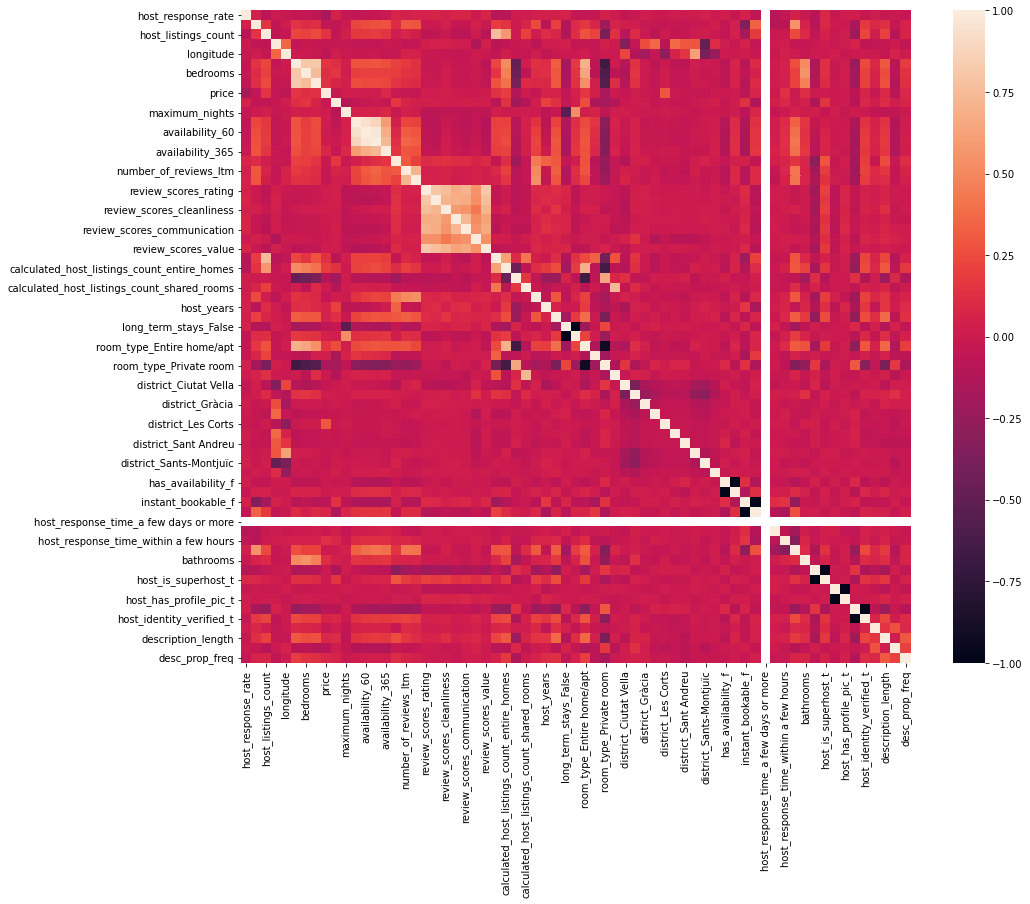

In [ ]:
plt.figure(figsize=(15,12))
corr_matrix = data.corr()
sns.heatmap(corr_matrix)

In [ ]:
data.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_years', 'num_amenities', 'long_term_stays_False',
       'long_term_stays_True', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room',

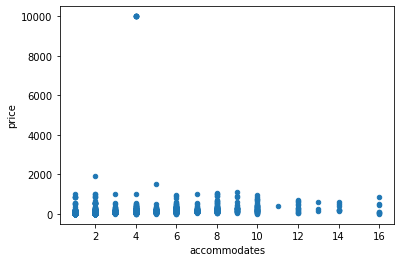

In [ ]:
data.plot.scatter(x='accommodates', y='price')
plt.show()

In [ ]:
'''for var in data:
    data.plot.scatter(x=var, y='price')'''

"for var in data:\n    data.plot.scatter(x=var, y='price')"

## Resampling

A lo largo de la práctica usaremos la validación cruzada para evaluar el rendimiento de nuestros modelos. Por eso, primero vamos a partir los datos en dos conjuntos disjuntos: uno de entrenamiento y uno de test.

In [ ]:
X = data.loc[:,data.columns != 'price']
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)

## Modelos lineales y cuadráticos

### Regresión lineal

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.18634699627974227

In [ ]:
lr.score(X_test, y_test)

0.20705256684611628

In [ ]:
poly = PolynomialFeatures(degree=2)
poly_X_train = poly.fit_transform(X_train)

poly_lr = LinearRegression().fit(poly_X_train, y_train)
poly_lr.score(poly_X_train, y_train)

0.98690689409411

In [ ]:
y_pred = poly_lr.predict(poly.transform(X_test))
r2_score(y_test, y_pred)

-454404608376.4989

Muchísimo overfitting.

In [ ]:
pi = permutation_importance(lr, X_test, y_test, n_repeats=30, random_state=0)
imp_features = list(zip(list(X_test.columns), pi.importances_mean))
imp_features.sort(key=lambda x:x[1], reverse=True)

#### *Feature importance*

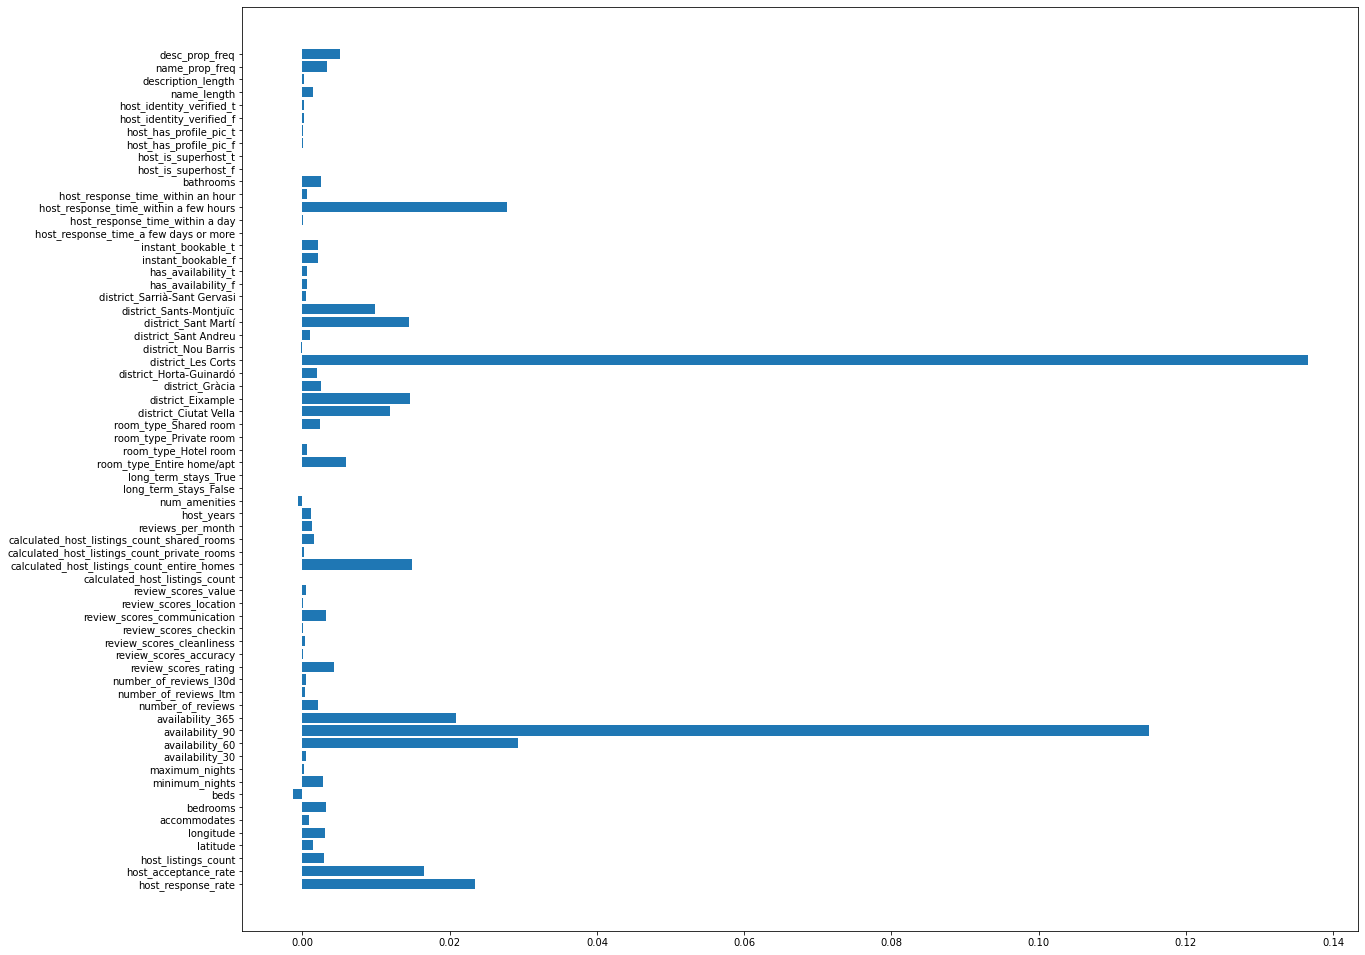

In [ ]:
plt.figure(figsize=(20,17))
y_pos = np.arange(len(list(X_test.columns)))
plt.barh(y_pos, pi.importances_mean)
plt.yticks(y_pos, X_test.columns)
plt.show()

#### *Polynomial Features* con las 10 variables más relevantes

In [ ]:
# las 10 caracteristicas mas relevantes
imp_features[:10]

[('district_Les Corts', 0.1365342976936069),
 ('availability_90', 0.11494613108655566),
 ('availability_60', 0.02923183813333879),
 ('host_response_time_within a few hours', 0.027844669235880734),
 ('host_response_rate', 0.023407071519600104),
 ('availability_365', 0.02091853641204986),
 ('host_acceptance_rate', 0.016576287439990216),
 ('calculated_host_listings_count_entire_homes', 0.014863348160959163),
 ('district_Eixample', 0.014549731182902611),
 ('district_Sant Martí', 0.014484246034343578)]

In [ ]:
vars = [x[0] for x in imp_features[:10]]

X_train_lr10 = X_train[vars]
X_test_lr10 = X_test[vars]

In [ ]:
lr10 = LinearRegression()
lr10.fit(X_train_lr10, y_train)
lr10.score(X_train_lr10, y_train)

0.15027281081818267

In [ ]:
lr10.score(X_test_lr10, y_test)

0.18398598831649993

In [ ]:
poly = PolynomialFeatures(degree=2)
poly_X_train = poly.fit_transform(X_train_lr10)

poly_lr10 = LinearRegression().fit(poly_X_train, y_train)
poly_lr10.score(poly_X_train, y_train)

0.8751244258689996

In [ ]:
y_pred = poly_lr10.predict(poly.transform(X_test_lr10))
r2_score(y_test, y_pred)

0.9304748930456809

### Regresión Ridge

In [ ]:
ridge = RidgeCV(alphas=[1, 5, 10, 100, 1000])
ridge.fit(X_train, y_train)
ridge.score(X_train, y_train)

0.18131785039121218

In [ ]:
ridge.score(X_test, y_test)

0.19365496862945353

### LASSO

In [ ]:
lasso = LassoCV(alphas=[1, 10, 100, 1000])
lasso.fit(X_train_sc, y_train)
lasso.score(X_train_sc, y_train)

0.18484037438600898

In [ ]:
lasso.score(X_test_sc, y_test)

0.2037074755532604

### K-NN

In [ ]:
parameters = {'n_neighbors': [1, 3, 5, 7],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'chebyshev']}
gs = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1, cv=10)
gs.fit(X_train_sc, y_train)
bknn = gs.best_estimator_
print(gs.best_score_, gs.best_params_)

0.678092849362284 {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
bknn.score(X_train_sc, y_train)

1.0

In [ ]:
bknn.score(X_test_sc, y_test)

0.9554882325315508

#### *Feature importance*

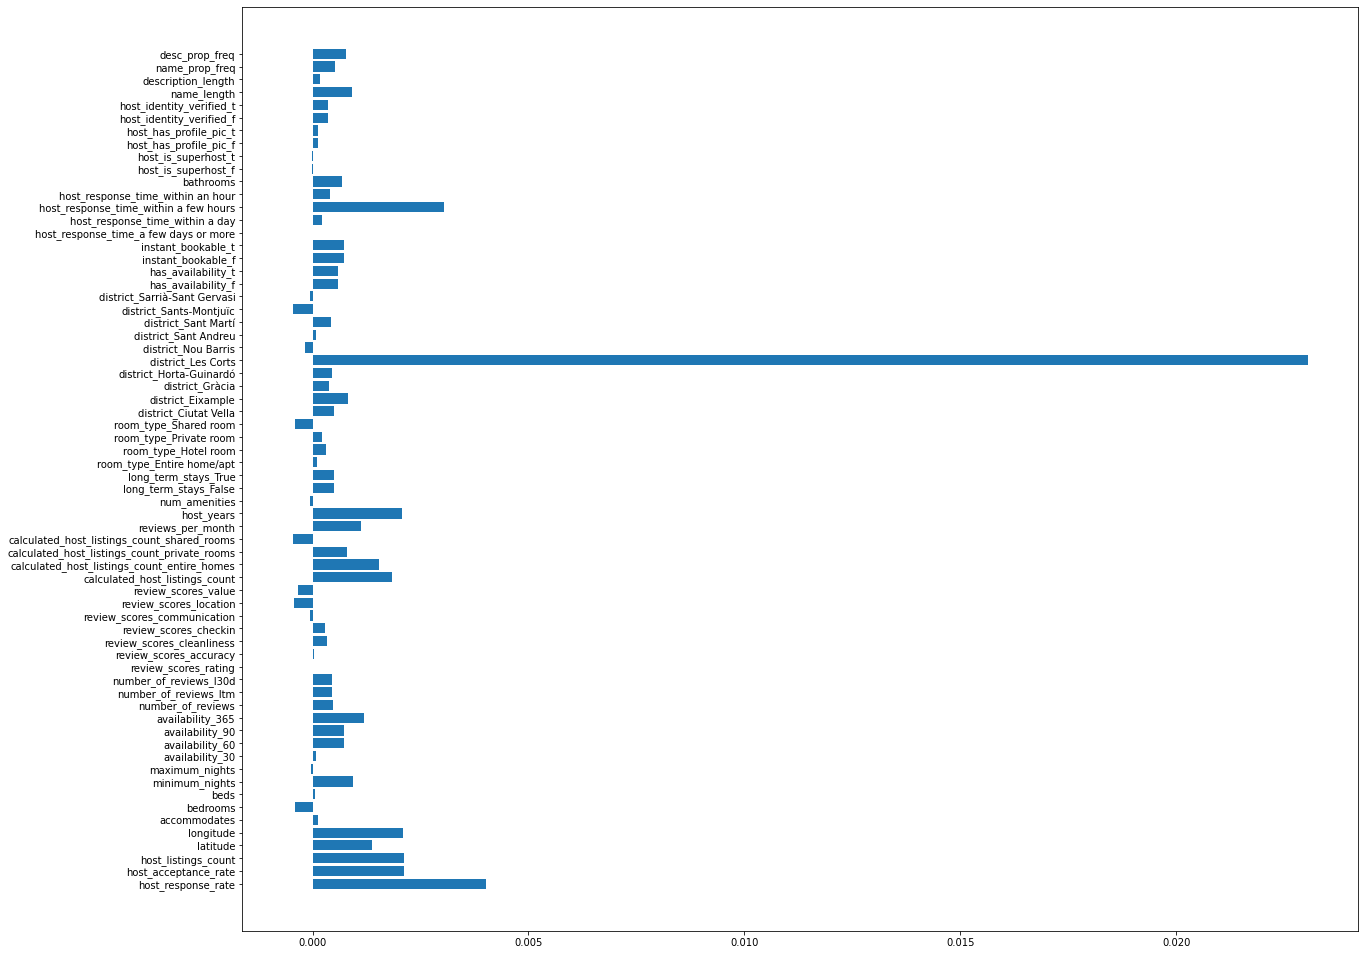

In [ ]:
pi = permutation_importance(bknn, X_test_sc, y_test, n_repeats=30, random_state=0)
list(zip(list(X_test.columns), pi.importances_mean))

plt.figure(figsize=(20,17))
y_pos = np.arange(len(list(X_test.columns)))
plt.barh(y_pos, pi.importances_mean)
plt.yticks(y_pos, X_test.columns)
plt.show()

### SVM lineal

In [ ]:
parameters = {'epsilon': [1e-4, 1, 1e2],
              'tol': [1e-9, 1e-7, 1e-4, 1e-2],
              'C': [1e-3, 1e-2, 1, 100],
              'fit_intercept': [True, False],
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
gs = GridSearchCV(LinearSVR(dual=False), parameters, n_jobs=-1, cv=10)
gs.fit(X_train_sc, y_train)
bsvml = gs.best_estimator_
print(gs.best_score_, gs.best_params_)

-0.477050395309249 {'C': 0.001, 'epsilon': 0.0001, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'tol': 1e-09}


In [ ]:
bsvml.score(X_train_sc, y_train)

0.17849035745854913

In [ ]:
bsvml.score(X_test_sc, y_test)

0.18941587822043715

### SVM cuadrática

In [ ]:
parameters = {'gamma': ['scale', 'auto'],
              'coef0': [0.1, 1, 10],
              'epsilon': [1e-2, 1, 1e2],
              'C': [1e-2, 1, 100, 1000, 2000, 3000]}
gs = GridSearchCV(SVR(kernel='poly', degree=2), parameters, n_jobs=-1, cv=3)
gs.fit(X_train_sc, y_train)
bsvmc = gs.best_estimator_
print(gs.best_score_, gs.best_params_)

In [ ]:
bsvmc = SVR(kernel='poly', degree=2, C=3000, epsilon=100, coef0=0.1, gamma='auto').fit(X_train_sc, y_train)

In [ ]:
bsvmc.score(X_train_sc, y_train)

0.9577067899955108

In [ ]:
bsvmc.score(X_test_sc, y_test)

0.9115391769146236

#### *Feature importance*

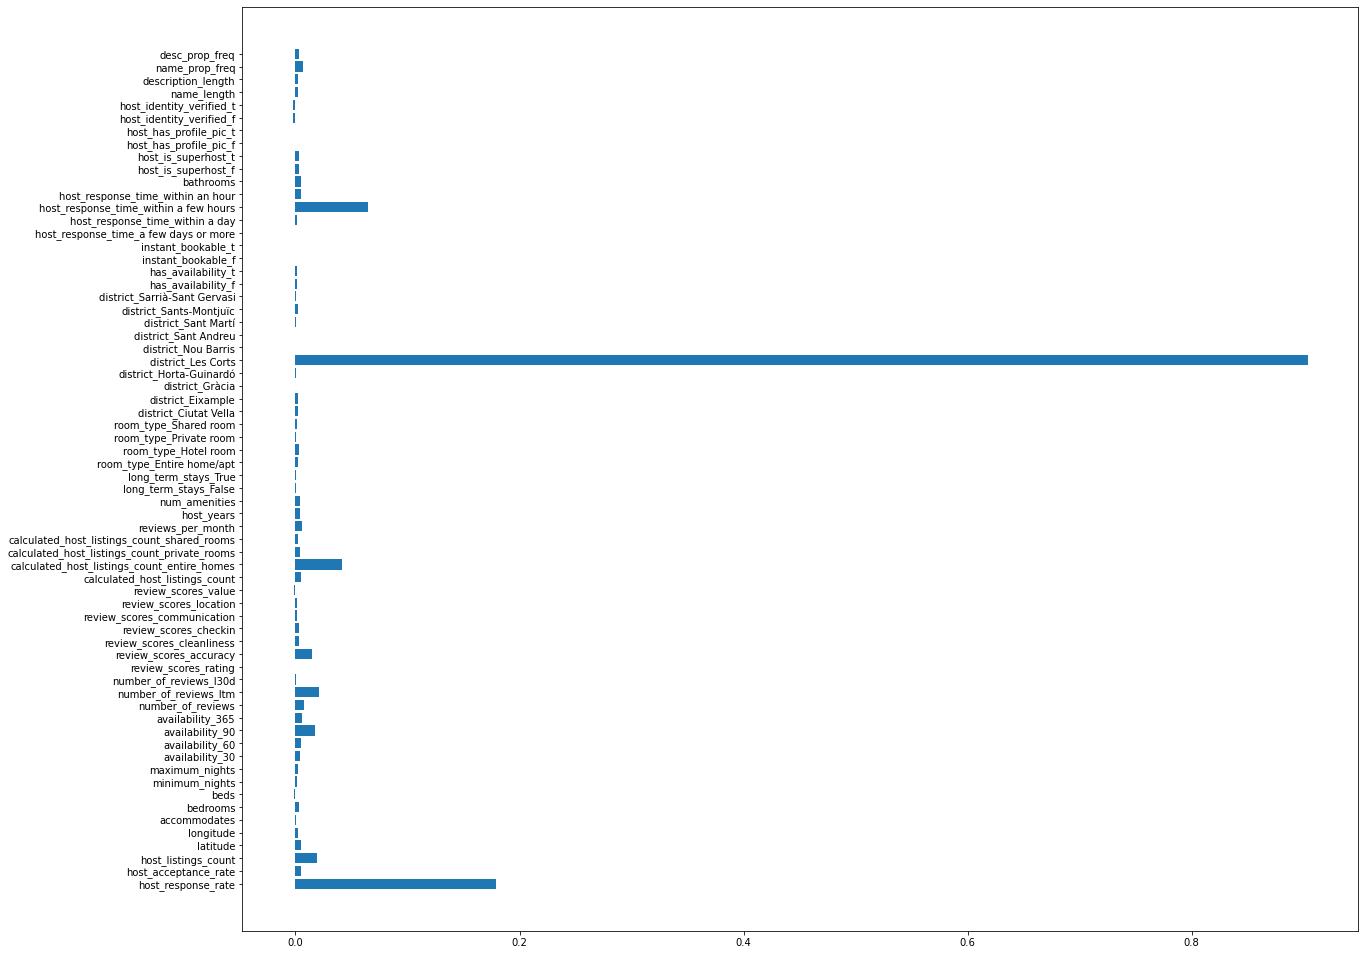

In [ ]:
pi = permutation_importance(bsvmc, X_test_sc, y_test, n_repeats=30, random_state=0)
list(zip(list(X_test.columns), pi.importances_mean))

plt.figure(figsize=(20,17))
y_pos = np.arange(len(list(X_test.columns)))
plt.barh(y_pos, pi.importances_mean)
plt.yticks(y_pos, X_test.columns)
plt.show()

## Modelos no lineales

### MLP

In [ ]:
parameters = {'hidden_layer_sizes': [50, 100],
              'activation': ['logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'adam']}
gs = GridSearchCV(MLPRegressor(random_state=0), parameters, n_jobs=-1, cv=10)
gs.fit(X_train_sc, y_train)
bmlp = gs.best_estimator_
print(gs.best_score_, gs.best_params_)

0.4220171939153053 {'activation': 'logistic', 'hidden_layer_sizes': 100, 'solver': 'lbfgs'}


In [ ]:
bmlp.score(X_train_sc, y_train)

0.9737294520526405

In [ ]:
bmlp.score(X_test_sc, y_test)

0.931972366132123

#### *Feature importance*

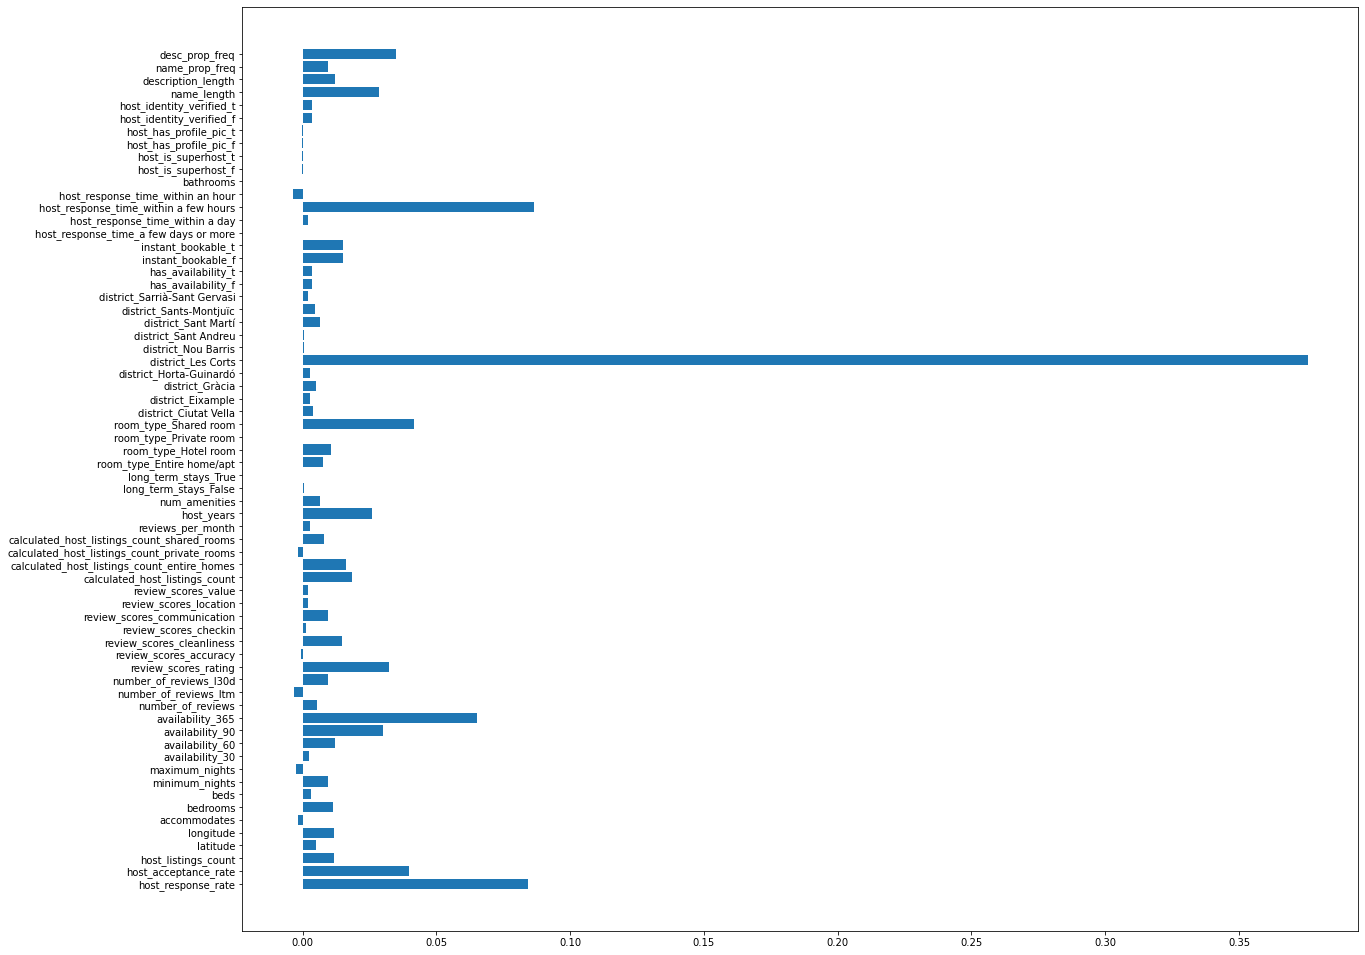

In [ ]:
pi = permutation_importance(bmlp, X_test_sc, y_test, n_repeats=30, random_state=0)
list(zip(list(X_test.columns), pi.importances_mean))

plt.figure(figsize=(20,17))
y_pos = np.arange(len(list(X_test.columns)))
plt.barh(y_pos, pi.importances_mean)
plt.yticks(y_pos, X_test.columns)
plt.show()

### SVM con kernel RBF

In [ ]:
parameters = {'epsilon': [0.01, 1, 10],
              'C': [1000, 2000, 5000],
              'gamma': ['scale', 'auto']}
gs = GridSearchCV(SVR(kernel='rbf'), parameters, n_jobs=-1)
gs.fit(X_train_sc, y_train)
brbf = gs.best_estimator_
print(gs.best_score_, gs.best_params_)

0.5203801986705103 {'C': 5000, 'epsilon': 0.01, 'gamma': 'scale'}


In [ ]:
brbf.score(X_train_sc, y_train)

0.9969320608021426

In [ ]:
brbf.score(X_test_sc, y_test)

0.9580886680439495

#### *Feature importance*

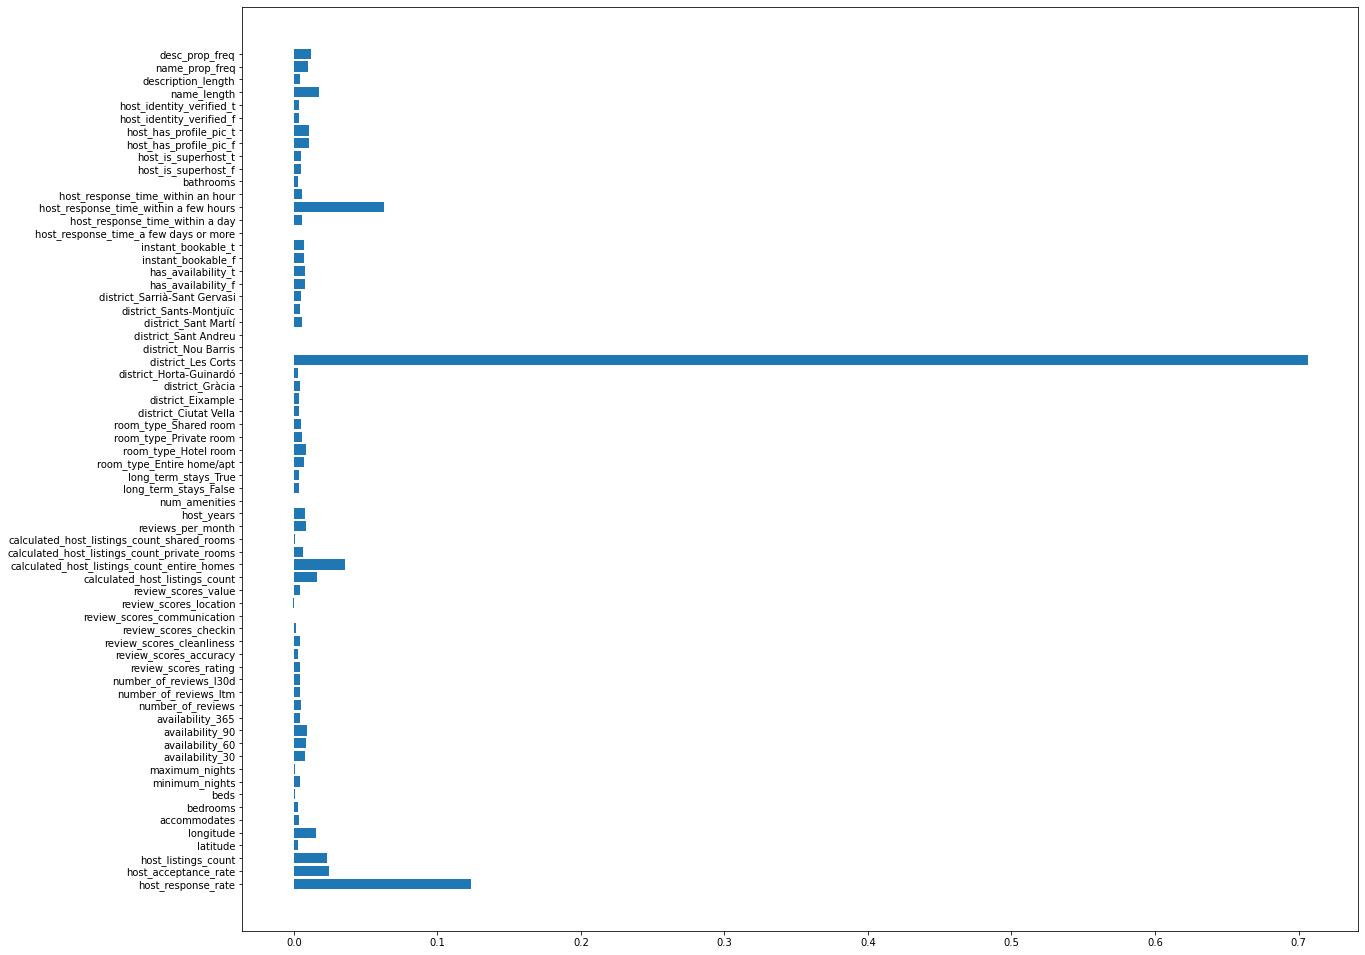

In [ ]:
pi = permutation_importance(brbf, X_test_sc, y_test, n_repeats=30, random_state=0)
list(zip(list(X_test.columns), pi.importances_mean))

plt.figure(figsize=(20,17))
y_pos = np.arange(len(list(X_test.columns)))
plt.barh(y_pos, pi.importances_mean)
plt.yticks(y_pos, X_test.columns)
plt.show()

### Random Forest

In [ ]:
parameters = {'n_estimators': [50, 100],
              'max_depth': range(2, 20, 5),
              'min_samples_split': range(2, 20, 5),
              'min_samples_leaf': range(1, 20, 5),
              'max_features': ['auto', 'sqrt', 'log2']}
rf = GridSearchCV(ensemble.RandomForestRegressor(), parameters, n_jobs=-1)
rf.fit(X_train, y_train)
f = rf.best_estimator_
print(rf.best_score_, rf.best_params_)

0.5583786205561562 {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
f.score(X_train, y_train)

0.9754450444371517

In [ ]:
f.score(X_test, y_test)

0.8738053175190218

#### *Feature importance*

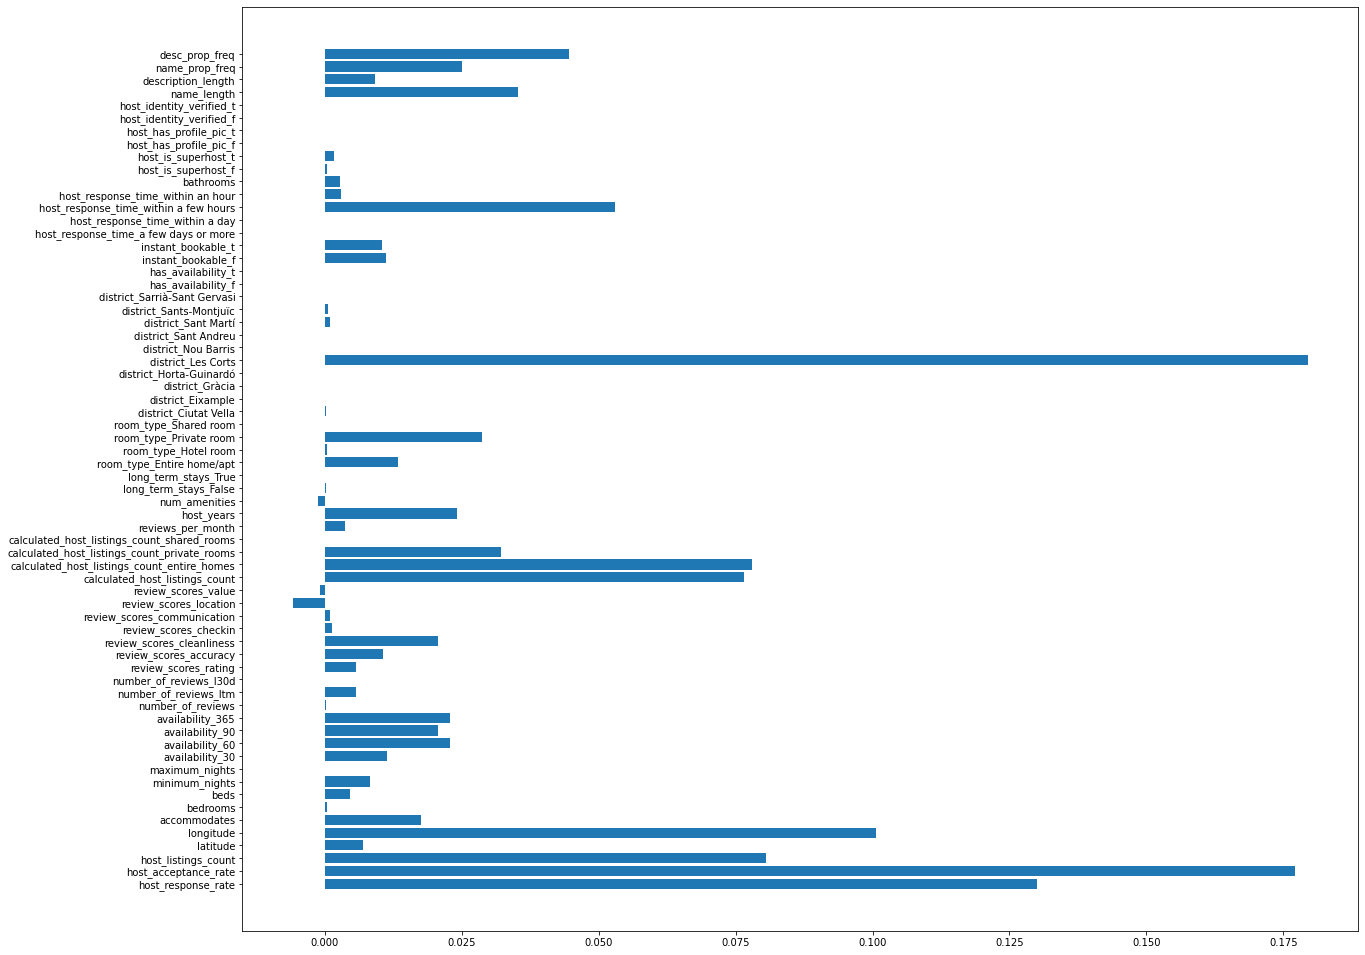

In [ ]:
pi = permutation_importance(f, X_test, y_test, n_repeats=30, random_state=0)
list(zip(list(X_test.columns), pi.importances_mean))

plt.figure(figsize=(20,17))
y_pos = np.arange(len(list(X_test.columns)))
plt.barh(y_pos, pi.importances_mean)
plt.yticks(y_pos, X_test.columns)
plt.show()

##Ejemplos

###Modelo no lineal

In [ ]:
y_test.quantile(q=0.10)

26.0

In [ ]:
xy_test = X_test
xy_test['price'] = y_test

#Precio bajo
ind =xy_test[xy_test.price <= 26].index
examplesNoLinear = xy_test.loc[ind[0:1]]
examplesNoLinear.index = ["PrecioBajo"]
print("Indice precio bajo es:" + str(ind[0]))

#Precio alto
ind2 = xy_test[xy_test.price >= xy_test.price.quantile(q=0.95)].index
examplesNoLinear.loc["PrecioAlto"] = xy_test.loc[ind2[0]]
print("Indice precio alto es:" + str(ind2[0]))
#Precio promedio
ind3 = xy_test[(xy_test.price <= (xy_test.price.mean()+10)) & (xy_test.price >= (xy_test.price.mean()-10))].index
examplesNoLinear.loc["PrecioPromedio"] = xy_test.loc[ind3[0]]
print("Indice precio medio es:" + str(ind3[0]))

#Outlier
examplesNoLinear
Q1 = data_before_outliers['price'].quantile(0.25)
Q3 = data_before_outliers['price'].quantile(0.75)
IQR = Q3 - Q1
small_outliers = data_before_outliers[data_before_outliers['price'] < (Q1 - 1.5*IQR)]
large_outliers = data_before_outliers[data_before_outliers['price'] > (Q3 + 1.5*IQR)]
ind4 = large_outliers.index
examplesNoLinear.loc["Outlier"] = data_before_outliers.loc[ind4[5]]
print("Indice precio outlier es:" + str(ind4[5]))
#{'C': 5000, 'epsilon': 0.01, 'gamma': 'scale'}



#Mala predicción
examplesNoLinear

Indice precio bajo es:2841
Indice precio alto es:9097
Indice precio medio es:13478
Indice precio outlier es:75


,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years,num_amenities,long_term_stays_False,long_term_stays_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,district_Ciutat Vella,district_Eixample,district_Gràcia,district_Horta-Guinardó,district_Les Corts,district_Nou Barris,district_Sant Andreu,district_Sant Martí,district_Sants-Montjuïc,district_Sarrià-Sant Gervasi,has_availability_f,has_availability_t,instant_bookable_f,instant_bookable_t,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,bathrooms,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,name_length,description_length,name_prop_freq,desc_prop_freq,price
PrecioBajo,100.0,0.853166,2.0,41.37893,2.16401,1.0,1.0,1.0,1.0,1125.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,4.54,4.71,4.54,4.67,4.67,4.79,4.38,1.0,0.0,1.0,0.0,0.41,7.0,457.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,50.0,684.0,0.133333,0.10,21.0
PrecioAlto,100.0,0.853166,1.0,41.40732,2.17545,4.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,5.00,5.00,5.00,5.00,5.00,5.00,4.86,1.0,0.0,1.0,0.0,0.25,3.0,441.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,49.0,745.0,0.066667,0.00,250.0
PrecioPromedio,100.0,0.980000,5.0,41.40996,2.17901,4.0,2.0,4.0,1.0,1125.0,23.0,53.0,83.0,121.0,5.0,5.0,0.0,4.40,4.60,4.80,5.00,5.00,4.80,4.20,4.0,4.0,0.0,0.0,1.30,4.0,300.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,40.0,1000.0,0.133333,0.09,119.0
Outlier,73.0,1.000000,3.0,41.37781,2.18445,10.0,4.0,6.0,2.0,14.0,23.0,53.0,83.0,354.0,25.0,1.0,0.0,4.79,4.85,4.75,5.00,4.90,4.75,4.75,2.0,2.0,0.0,0.0,0.36,11.0,275.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,56.0,284.0,0.066667,0.04,1500.0


In [ ]:
#Example of bad prediction
mysvr = SVR(kernel='rbf', C=5000, epsilon = 0.01, gamma = 'scale')
mysvr.fit(X_train_sc, y_train)
predicts = mysvr.predict(X_test_sc)
y_diff = abs(predicts - y_test)
y_diff = pd.DataFrame(y_diff, columns=["price"])
ind5 = y_diff[y_diff.price == y_diff.price.max()].index
examplesNoLinear.loc["BadPrediction"] = xy_test.loc[ind5[0]]
examplesNoLinear
print("Indice mala prediccion es:" + str(ind5[0]))




Indice mala prediccion es:3820


In [ ]:
#Arquetipical

examplesNoLinear.loc["Arquetipico"] = xy_test.mean()
examplesNoLinear


,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years,num_amenities,long_term_stays_False,long_term_stays_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,district_Ciutat Vella,district_Eixample,district_Gràcia,district_Horta-Guinardó,district_Les Corts,district_Nou Barris,district_Sant Andreu,district_Sant Martí,district_Sants-Montjuïc,district_Sarrià-Sant Gervasi,has_availability_f,has_availability_t,instant_bookable_f,instant_bookable_t,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,bathrooms,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,name_length,description_length,name_prop_freq,desc_prop_freq,price
PrecioBajo,100.000000,0.853166,2.000000,41.378930,2.164010,1.000000,1.000000,1.000000,1.000000,1125.000000,0.000000,0.00000,0.000000,0.000000,25.000000,0.00000,0.00000,4.540000,4.71000,4.540000,4.670000,4.670000,4.79000,4.380000,1.000000,0.000000,1.000000,0.000000,0.410000,7.000000,457.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,50.000000,684.000000,0.133333,0.100000,21.000000
PrecioAlto,100.000000,0.853166,1.000000,41.407320,2.175450,4.000000,2.000000,2.000000,4.000000,8.000000,0.000000,0.00000,0.000000,0.000000,7.000000,0.00000,0.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,4.860000,1.000000,0.000000,1.000000,0.000000,0.250000,3.000000,441.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,49.000000,745.000000,0.066667,0.000000,250.000000
PrecioPromedio,100.000000,0.980000,5.000000,41.409960,2.179010,4.000000,2.000000,4.000000,1.000000,1125.000000,23.000000,53.00000,83.000000,121.000000,5.000000,5.00000,0.00000,4.400000,4.60000,4.800000,5.000000,5.000000,4.80000,4.200000,4.000000,4.000000,0.000000,0.000000,1.300000,4.000000,300.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,40.000000,1000.000000,0.133333,0.090000,119.000000
Outlier,73.000000,1.000000,3.000000,41.377810,2.184450,10.000000,4.000000,6.000000,2.000000,14.000000,23.000000,53.00000,83.000000,354.000000,25.000000,1.00000,0.00000,4.790000,4.85000,4.750000,5.000000,4.900000,4.75000,4.750000,2.000000,2.000000,0.000000,0.000000,0.360000,11.000000,275.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,56.000000,284.000000,0.066667,0.040000,1500.000000
BadPrediction,100.000000,0.853166,2.000000,41.428740,2.165480,2.000000,1.000000,1.000000,5.000000,1125.000000,0.000000,0

In [ ]:
examplesNLX = examplesNoLinear.drop(columns=['price'])
examplesNLX_sc = scaler.transform(examplesNLX)

examplesNLY = mysvr.predict(examplesNLX_sc)
examplesNoLinear['pricePrediction'] = examplesNLY
examplesNoLinear

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years,num_amenities,long_term_stays_False,long_term_stays_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,district_Ciutat Vella,district_Eixample,district_Gràcia,district_Horta-Guinardó,district_Les Corts,district_Nou Barris,district_Sant Andreu,district_Sant Martí,district_Sants-Montjuïc,district_Sarrià-Sant Gervasi,has_availability_f,has_availability_t,instant_bookable_f,instant_bookable_t,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,bathrooms,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,name_length,description_length,name_prop_freq,desc_prop_freq,price,pricePrediction
PrecioBajo,100.000000,0.853166,2.000000,41.378930,2.164010,1.000000,1.000000,1.000000,1.000000,1125.000000,0.000000,0.00000,0.000000,0.000000,25.000000,0.00000,0.00000,4.540000,4.71000,4.540000,4.670000,4.670000,4.79000,4.380000,1.000000,0.000000,1.000000,0.000000,0.410000,7.000000,457.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,50.000000,684.000000,0.133333,0.100000,21.000000,90.586022
PrecioAlto,100.000000,0.853166,1.000000,41.407320,2.175450,4.000000,2.000000,2.000000,4.000000,8.000000,0.000000,0.00000,0.000000,0.000000,7.000000,0.00000,0.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,4.860000,1.000000,0.000000,1.000000,0.000000,0.250000,3.000000,441.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,49.000000,745.000000,0.066667,0.000000,250.000000,88.651222
PrecioPromedio,100.000000,0.980000,5.000000,41.409960,2.179010,4.000000,2.000000,4.000000,1.000000,1125.000000,23.000000,53.00000,83.000000,121.000000,5.000000,5.00000,0.00000,4.400000,4.60000,4.800000,5.000000,5.000000,4.80000,4.200000,4.000000,4.000000,0.000000,0.000000,1.300000,4.000000,300.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,40.000000,1000.000000,0.133333,0.090000,119.000000,118.557507
Outlier,73.000000,1.000000,3.000000,41.377810,2.184450,10.000000,4.000000,6.000000,2.000000,14.000000,23.000000,53.00000,83.000000,354.000000,25.000000,1.00000,0.00000,4.790000,4.85000,4.750000,5.000000,4.900000,4.75000,4.750000,2.000000,2.000000,0.000000,0.000000,0.360000,11.000000,275.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,56.000000,284.000000,0.066667,0.040000,1500.000000,171.783320
BadPrediction,100.000000,0.853166,2.000000,41.428740,2.165480,